
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReeW-Q : Overtopping estimation 

inputs required: 
  * Nearshore reconstructed historical storms
  * Nearshore reconstructed simulated storms
  * Historical water levels
  * Synthetic water levels 

in this notebook:
  * HyCReWW-Q overtopping estimation of historical and synthetic events
  * Extreme value analysis and validation

**HyCReWW - Q** provides wave-driven overtopping estimations along coral reef-lined shorelines under a wide range of fringing reef morphologies and offshore forcing characteristics. The metamodel is based on two models: (a) a full factorial design of recent XBeach Non-Hydrostatic simulations under different reef configurations and offshore wave and water level conditions (Pearson et al, 2017); and (b) Radial Basis Functions (RBFs) for approximating the non-linear function of overtopping for the set of multivariate parameters:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Runup = RBF($\eta_0$, $H_0$, ${H_0/L_0}$, $\beta_f$,$W_{reef}$, $\beta_b$, $c_f$, $Z_b$ );&nbsp;&nbsp;&nbsp;&nbsp;</center>

Where, the hydrodynamic variables defined are offshore water level ($\eta_0$), significant wave height ($H_0$), and wave steepness (${H_0/L_0}$); the reef morphologic parameters include fore reef slope ($\beta_f$), reef flat width ($W_reef$), beach slope ($\beta_b$), seabed roughness ($c_f$) and beach crest elevation ($Z_b$). ${L_0}$ is the deep water wave length $L_0=gT_p^2/2pi$, and $T_p$ is the peak period.

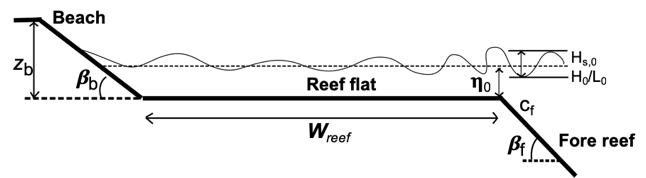

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import linregress

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize
from teslakit.statistical import runmean
from teslakit.tides import Calculate_MMSL


from teslakit.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


# --------------------------------------
# parameters for mmsl calculation
mmsl_year_ini = 1996
mmsl_year_end = 2017


# --------------------------------------
# load Hycreww RBF coefficients and sim. variables min. and max.

# reef characteristics
# reef_cs = {
#     'rslope': 0.0505,
#     'bslope': 0.1667,
#     'rwidth': 250,
#     'Zr': 2.5,
#     'cf': 0.0105,
# }

var_lims, rbf_coeffs = db.Load_HYCREWW_Q()


In [3]:
# HyCReWW Function

def hycreww_Q(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (WL, Hs, Tp, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf )
    
    '''
    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'Zb', 'cf']

    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4, 5]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]


    # discard data outside limits
#     for vn in var_lims.keys():
#         dset = dset.isel(num=np.where((dset[vn] >= var_lims[vn][0]) & (dset[vn] <= var_lims[vn][1]))[0])


    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]
    ds_in=([dset.level.values],[dset.rslope.values],[dset.bslope.values],[dset.rwidth.values],[dset.Zb.values],[dset.cf.values])
    ds_in=np.transpose(ds_in)[:,0,:]

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)

    # Q Linear interpolation (hs, hs_lo -> runup)
    Q = []
    for c  in range(len(dset.num)):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (dset.hs.values[c], dset.hs_lo2.values[c]), method='linear')
        Q.append(vq)
    Q = np.array(Q)

    # store runup alongside input data
    dset_out = dset.copy()
    dset_out['Q'] = Q

    return dset_out


## Hycreww RBF Interpolation

### VARIABLES

##### Historical levels:

In [16]:
# --------------------------------------
# Astronomical Tide (AT)

_, TIDE = db.Load_TIDE_hist()  
TIDE = TIDE.drop_vars('ntr')
TIDE = TIDE.drop_vars('sigma')
print(TIDE)

time = TIDE.time.values[:]
AT = (TIDE.predicted - np.nanmean(TIDE.predicted.values[:])) 


<xarray.Dataset>
Dimensions:    (time: 184104)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 ... 2016-12-31T23:00:00.000002944
Data variables:
    observed   (time) float64 ...
    predicted  (time) float64 ...


SystemExit: 

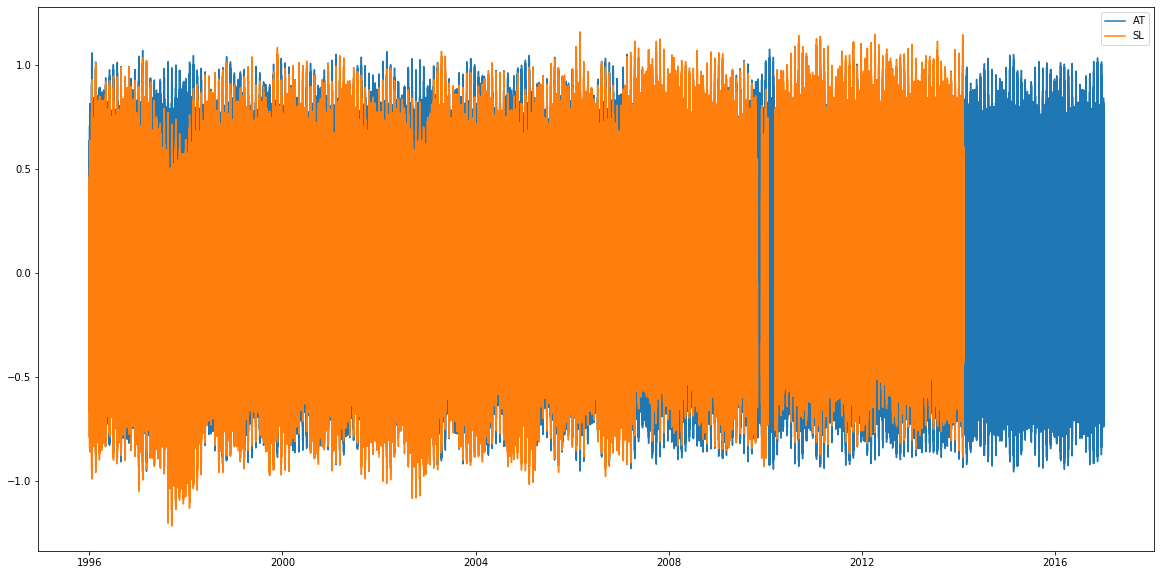

In [18]:
# --------------------------------------
# Monthly Mean Sea Level (MMSL)

SL = (TIDE.observed - np.nanmean(TIDE.observed.values[:]))

# obtain SLR
lr_time = np.array(range(len(time)))  # for linregress
ind_nan = np.where(~np.isnan(SL.values)) # ind no NaNs
slope, intercept, r_value, p_value, std_err = linregress(lr_time[ind_nan], SL.values[ind_nan])
slr = intercept + slope * lr_time

# Plot tide with SLR
#Plot_Tide_SLR(time, SL, slr);

# remove SLR and runmean from tide 
SL_noslr = SL - slr

# calculate running mean
time_window = 365*24*3
runm = runmean(SL_noslr, time_window, 'mean')

# Plot SL without SLR and runm
#Plot_Tide_RUNM(time, SL_noslr, runm);

# remove running mean
SL_noslr_norunm = SL_noslr - runm

# store data 
SLNSR = xr.DataArray(SL_noslr_norunm,  dims=('time'), coords={'time':time})

# calculate MMSL
MMSL = Calculate_MMSL(SLNSR, mmsl_year_ini, mmsl_year_end)
mmsl_time = MMSL.time.values[:]
mmsl_vals = MMSL.mmsl.values[:]

# Plot tide and mmsl 
Plot_Tide_MMSL(SLNSR.time, SLNSR.values, mmsl_time, mmsl_vals);

# store historical mmsl
db.Save_TIDE_hist_mmsl(MMSL)


# from monthly to hourly
MMSL = MMSL.mmsl.resample(time='1H').interpolate("linear")


In [6]:
# --------------------------------------
# Inverse Barometer (IB)

SLP = db.Load_ESTELA_SLP()                # Sea Level Pressure from CFSR (Pa)
SLP_p = SLP.sel(longitude = 168, latitude = 8) # pnt_lon = 167.73, pnt_lat = 8.66


IB = xr.Dataset({'SLP': (('time',), ((SLP_p.SLP - np.mean(SLP_p.SLP.values)) * 0.01))}, # (mb)
                         coords = {'time': SLP_p.time.values})

IB['level'] = (('time'), -1*IB.SLP) # (cm)


<xarray.DataArray 'predicted' (time: 183336)>
array([ 0.40100827,  0.56500827,  0.61900827, ..., -0.24999173,
       -0.55799173, -0.73199173])
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2016-12-15T23:00:00
<xarray.DataArray 'mmsl' (time: 183336)>
array([-0.03198849, -0.03184205, -0.03169561, ...,         nan,
               nan,         nan])
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2016-12-15T23:00:00
Attributes:
    units:       meters
    short_name:  mmsl
    long_name:   monthly mean sea level
<xarray.Dataset>
Dimensions:  (time: 183336)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2016-12-15T23:00:00
Data variables:
    SLP      (time) float64 0.7054 -0.3889 -0.8767 ... -0.967 -0.6934 -0.6248
    level    (time) float64 -0.7054 0.3889 0.8767 1.007 ... 0.967 0.6934 0.6248


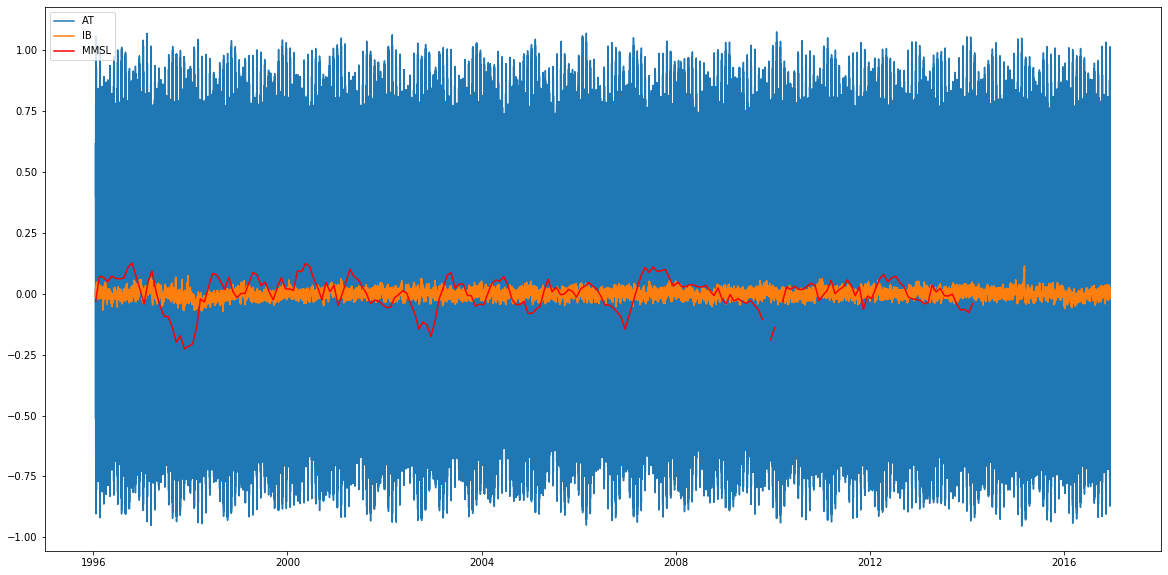

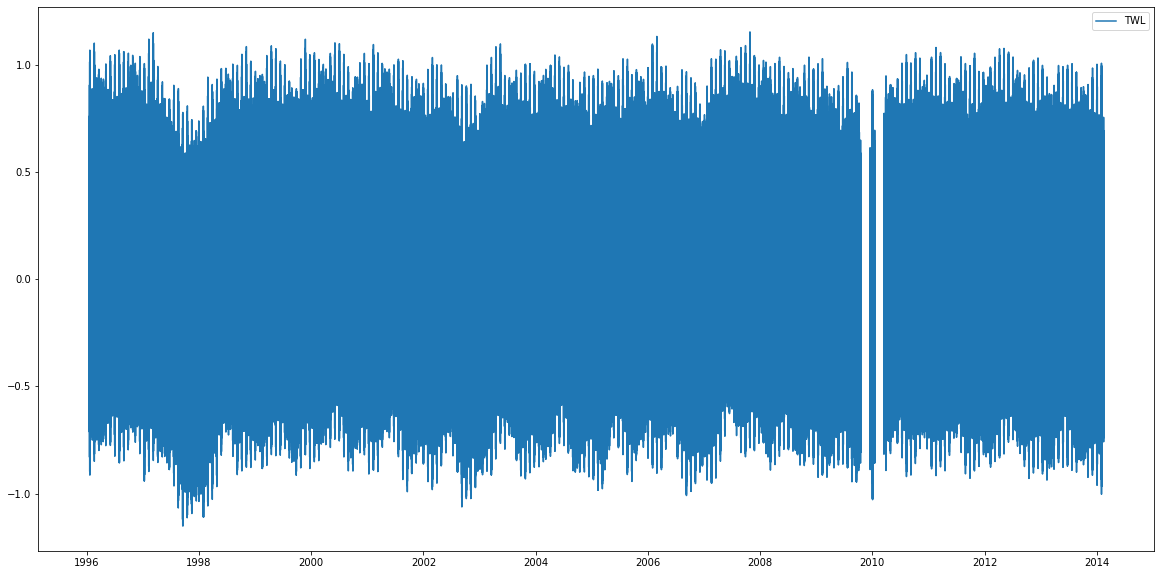

In [19]:
# --------------------------------------
# Compute Level

# hourly values
AT['time'] = AT['time'].dt.round('H')
MMSL['time'] = MMSL['time'].dt.round('H')
IB['time'] = IB['time'].dt.round('H')

# remove duplicates
_, ix = np.unique(AT['time'], return_index=True); AT = AT.isel(time=ix)
_, ix = np.unique(MMSL['time'], return_index=True); MMSL = MMSL.isel(time=ix)
_, ix = np.unique(IB['time'], return_index=True); IB = IB.isel(time=ix)


# get common dates
AT = AT.sel(time = slice('1996-01-17', '2016-12-15'))
MMSL = MMSL.sel(time = slice('1996-01-17', '2016-12-15'))
IB = IB.sel(time = slice('1996-01-17', '2016-12-15'))

print(AT)
print(MMSL)
print(IB)

level = AT + MMSL + IB.level/100.0

plt.figure(figsize=(20,10))
plt.plot(AT.time, AT, label='AT')
plt.plot(IB.time, IB.level/100.0, label='IB')
plt.plot(MMSL.time, MMSL, color = 'r', label='MMSL')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(level.time, level, label = 'TWL')
plt.legend()

##### WL, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf

In [ ]:
data=np.loadtxt(op.join(p_data, 'inputs_Kwajalein/HyCReWW-Q/RBF_coefficients_Q/Example_k15_variables.txt'))
dset = xr.Dataset(
            {   'hs':(('num'),data[:,1]),
                'level':(('num'),data[:,0]),
                'tp':(('num'), data[:,2]),
                'bslope':(('num'), data[:,4]),
                'rslope':(('num'), data[:,3]),
                'rwidth':(('num'), data[:,5]),
                'Zb':(('num'), data[:,6]),
                'cf':(('num'), data[:,7]),
            },coords = {'num':(('num'), np.arange(np.shape(data)[0]))})
dset['hs_lo2'] = (['num'],dset.hs.values/(1.5613*dset.tp.values**2))

print(dset)

### HyCReWW-Q

In [ ]:
out_sim = hycreww_Q(var_lims, rbf_coeffs, dset)
out_sim

### We undo the box-cox transformation

In [ ]:
from scipy.special import boxcox, inv_boxcox
out_sim['Qinv']=inv_boxcox(out_sim.Q.values, 0.2)

In [ ]:
# Data for validation
Qdata=np.loadtxt(os.path.join(path_coef,'Example_k15_Q.txt'))
Qdata=inv_boxcox(Qdata, 0.2)

### Plot

In [ ]:
plt.figure(figsize=[9,9])
plt.loglog([0,20000],[0,20000],'k-',linewidth=1.4)
plt.loglog(out_sim.Qinv,Qdata,'.',color='orchid',markersize=12)
plt.axis([0, 20000, 0, 20000])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Data', fontsize=15)